# Домашнее задание №1 - Метод К-ближайших соседей (K-neariest neighbors)

Сегодня мы с вами реализуем наш первый алгоритм машинного обучения, метод К-ближайших соседей. Мы попытаемся решить с помощью него задачи:
- бинарной классификации (то есть, только двум классам)
- многоклассовой классификации (то есть, нескольким классам)
- регрессии (когда зависимая переменная - натуральное число)

Так как методу необходим гиперпараметр (hyperparameter) - количество соседей, то нам нужно научиться подбирать этот параметр. Мы постараемся научиться пользовать numpy для векторизованных вычислений, а также посмотрим на несколько метрик, которые используются в задачах классификации и регрессии.

Перед выполнением задания:
- установите все необходимые библиотеки, запустив `pip install -r requirements.txt`

Если вы раньше не работали с numpy или позабыли его, то можно вспомнить здесь:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd


from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from knn import KNNClassifier
from metrics import binary_classification_metrics, multiclass_accuracy

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

## Задание 1. KNN на датасете Fashion-MNIST (10 баллов)

В этом задании вам предстоит поработать с картинками одежды, среди которых можно выделить 10 классов. Данные уже загружены за вас: в переменной X лежат 70000 картинок размером 28 на 28 пикселей, вытянутые в вектор размерностью 784 (28 * 28). Так как данных довольно много, а наш KNN будет весьма медленный, то возьмем случайно 1000 наблюдений (в реальности в зависимости от вашей реализации можно будет взять больше, но если будет не зватать ОЗУ, то берите меньше).

In [3]:
X, y = fetch_openml(name="Fashion-MNIST", return_X_y=True, as_frame=False)

In [4]:
idx_to_stay = np.random.choice(np.arange(X.shape[0]), replace=False, size=1000)
X = X[idx_to_stay]
y = y[idx_to_stay]

Давайте посмотрим на какое-нибудь изображение из наших данных:

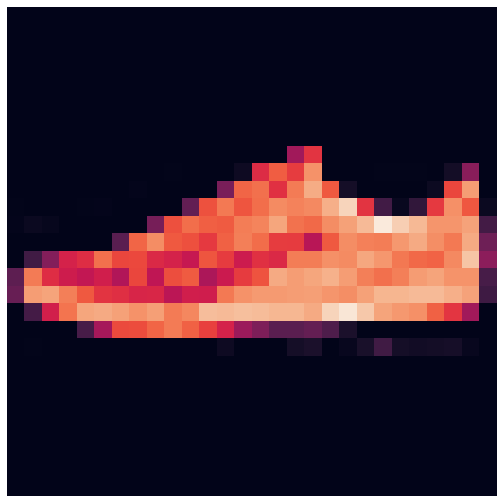

In [5]:
# возьмем случайную картинку и сделаем reshape
# 28, 28, 1 = H, W, C (число каналов, в данном случае 1)
image = X[np.random.choice(np.arange(X.shape[0]))].reshape(28, 28, 1)
plt.imshow(image)
plt.axis("off");

### 1.1. Посмотрим на все классы (0.5 баллов)

Возьмите по одной картинке каждого класса и изобразите их (например, сделайте subplots 5 на 2).

<Figure size 864x648 with 0 Axes>

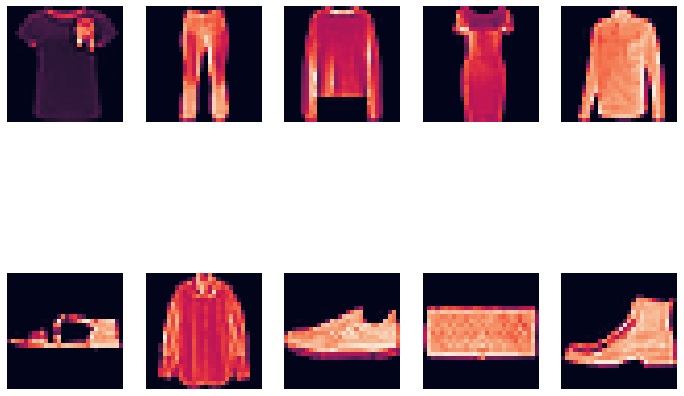

In [6]:
plt.figure()

y_class = [2, 5, 8, 6, 34, 0, 18, 22, 13, 1]

fig, axes = plt.subplots(nrows = 2, ncols = 5)

for ax in axes.flatten():
    ax.axis('off')

for i in range(5):
    image = X[y_class[i]].reshape(28, 28, 1)
    axes[0,i].imshow(image)

for i in range(5):
    image = X[y_class[5+i]].reshape(28, 28, 1)
    axes[1,i].imshow(image)
plt.show()

### 1.2. Сделайте небольшой EDA (1 балл)

Посмотрите на баланс классов. В дальнейших домашках делайте EDA, когда считаете нужным, он нужен почти всегда, но оцениваться это уже не будет, если не будет указано иное. Делайте EDA, чтобы узнать что-то новое о данных!

In [7]:
print('Class: frequency (%)')
(uniq, freq) = (np.unique(y, return_counts=True))
for i in range(10): print(f'{uniq[i]}: {freq[i]/10} %')

Class: frequency (%)
0: 9.3 %
1: 10.2 %
2: 9.5 %
3: 12.1 %
4: 9.6 %
5: 9.8 %
6: 10.1 %
7: 7.9 %
8: 10.9 %
9: 10.6 %


### 1.3. Разделите данные на train и test (0.5 баллов)

Разделите данные на тренировочную и тестовую выборки, размеры тестовой выборки выберите сами. Здесь вам может помочь функция `train_test_split`

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.70)

### 1.4. KNN для бинарной классификации (6 баллов)

Давайте возьмем для задачи бинарной классификации только объекты с метками классов 0 и 1.

In [9]:
index = []
for i in range(len(y_train)):
    if y_train[i] != '1' and y_train[i] != '0':
        index.append(i)
binary_train_y = np.delete(y_train, index).astype(np.int64)
binary_train_X = np.delete(X_train, index, axis=0)

In [10]:
index = []
for i in range(len(y_test)):
    if y_test[i] != '1' and y_test[i] != '0':
        index.append(i)
binary_test_y = np.delete(y_test, index).astype(np.int64)
binary_test_X = np.delete(X_test, index, axis=0)

И вот мы подготовили данные, но модели у нас пока что нет. В нескольких занятиях нашего курса вам придется самостоятельно реализовывать какие-то алгоритмы машинного обучения, а потом сравнивать их с готовыми библиотечными решениями. В остальных заданиях реализовывать алгоритмы будет не обязательно, но может быть полезно, поэтому часто это будут задания на дополнительные баллы, но главное не это, а понимание работы алгоритма после его реализации с нуля на простом numpy. Также это все потом можно оформить в виде репозитория ml_from_scratch и хвастаться перед друзьями.

In [11]:
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

### Настало время писать код!

В KNN нам нужно для каждого тестового примера найти расстояния до всех точек обучающей выборки. Допустим у нас 1000 примеров в train'е и 100 в test'е, тогда в итоге мы бы хотели получить матрицу попарных расстояний (например, размерностью 100 на 1000). Это можно сделать несколькими способами, и кому-то наверняка, в голову приходит идея с двумя вложенными циклами (надеюсь, что не больше:). Так можно делать, то можно и эффективнее. Вообще, в реальном KNN используется структура данных [k-d-tree](https://ru.wikipedia.org/wiki/K-d-%D0%B4%D0%B5%D1%80%D0%B5%D0%B2%D0%BE), которая позволяет производить поиск за log(N), а не за N, как будем делать мы (по сути это такое расширение бинарного поиска на многомерное пространство).

Вам нужно будет последовательно реализовать методы `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops` класса `KNN` в файле `knn.py`.

Эти функции строят массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате они должны построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

**Обратите внимание** Для простоты реализации мы будем использовать в качестве расстояния меру L1 (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)).

$d_{1}(\mathbf {p} ,\mathbf {q} )=\|\mathbf {p} -\mathbf {q} \|_{1}=\sum _{i=1}^{n}|p_{i}-q_{i}|$

В начале я буду иногда писать разные assert'ы, чтобы можно было проверить правильность реализации, в дальнейшем вам нужно будет их писать самим, если нужно будет проверять корректность каких-то вычислений.

In [12]:
# compute_distances_two_loops
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

In [13]:
# compute_distances_one_loop
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

In [14]:
# compute_distances_no_loops
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

Проверим скорость работы реализованных методов

In [15]:
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

82.2 ms ± 4.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
15.5 ms ± 2.11 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
59.6 ms ± 3.79 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Реализуем метод для предсказания меток класса

In [16]:
prediction = knn_classifier.predict(binary_test_X)

### Метрика

Теперь нужно реализовать несколько метрик для бинарной классификации. Не забудьте подумать о численной нестабильности (деление на 0).

In [17]:
binary_classification_metrics(prediction, binary_test_y)

accuracy: 0.984
precision: 0.967
recall: 1.0
F1 score: 0.983


Все ли хорошо с моделью? Можно проверить свою реализацию с функциями из библиотеки `sklearn`:

<img src="https://i.imgflip.com/406fu9.jpg" width="800" height="400">

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [19]:
print('Precision: %.3f' % precision_score(binary_test_y, prediction)) 
print('Recall: %.3f' % recall_score(binary_test_y, prediction)) 
print('F1 Score: %.3f' % f1_score(binary_test_y, prediction)) 
print('Accuracy: %.3f' % accuracy_score(binary_test_y, prediction)) 

Precision: 0.967
Recall: 1.000
F1 Score: 0.983
Accuracy: 0.984


### Подбор оптимального k

Чтобы подрбрать оптимальное значение параметра k можно сделать следующее: задать область допустимых значений k, например, `[1, 3, 5, 10]`. Дальше для каждого k обучить модель на тренировочных данных, сделать предсказания на тестовых и посчитать какую-нибудь метрику (метрику выберите сами исходя из задачи, но постарайтесь обосновать выбор). В конце нужно посмотреть на зависимость метрики на train'е и test'е от k и выбрать подходящее значение.

Реализуйте функцию `choose_best_k` прямо в ноутбуке.

In [20]:
from sklearn.neighbors import KNeighborsClassifier 


def find_best_k(X_train, y_train, X_test, y_test, params):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    
    neighbors = np.array(params) 
    train_metrics = np.empty(len(neighbors)) 
    test_metrics = np.empty(len(neighbors))
    for i, k in enumerate(neighbors): 
        knn_model = KNeighborsClassifier(n_neighbors=k)
        knn_model.fit(X_train, y_train) 
      
        train_metrics[i] = knn_model.score(X_train, y_train) 
        test_metrics[i] = knn_model.score(X_test, y_test) 
    return train_metrics, test_metrics
    

In [21]:
params = [1, 2, 4, 5, 8, 10, 30]
train_metrics, test_metrics = find_best_k(binary_train_X, binary_train_y, binary_test_X, binary_test_y, params)

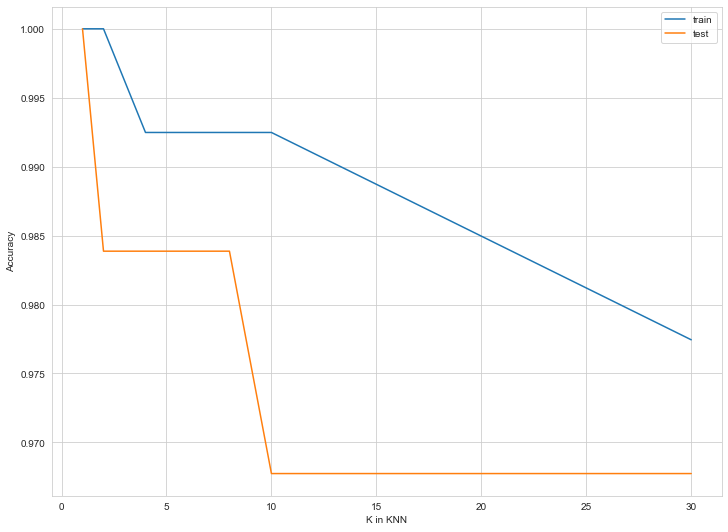

In [22]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")

plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("Accuracy");

Оптимальное значение k = 4 и k = 8. Примем за оптимальное значение k = 4.

На самом деле, это не самый лучший способ подбирать гиперпараметры, но способы получше мы рассмотрим в следующий раз, а пока что выберите оптимальное значение k, сделайте предсказания и посмотрите, насколько хорошо ваша модель предсказывает каждый из классов.

In [23]:
knn_classifier = KNNClassifier(k=4)
knn_classifier.fit(binary_train_X, binary_train_y)
prediction = knn_classifier.predict(binary_test_X)
binary_classification_metrics(prediction, binary_test_y)

accuracy: 0.984
precision: 1.0
recall: 0.966
F1 score: 0.982


### 1.5. Многоклассоввая классификация (2 балла)

Теперь нужно научиться предсказывать все 10 классов. Для этого в начале напишем соответствующий метод у нашего классификатора.

In [24]:
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

In [25]:
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(X_train, y_train)
predictions = knn_classifier.predict(X_test)

Осталось реализовать метрику качества для многоклассовой классификации, для этого реализуйте функцию `multiclass_accuracy` в `metrics.py`.

In [26]:
multiclass_accuracy(predictions, y_test)

0.763

Снова выберите оптимальное значение K как мы делали для бинарной классификации.

## Задание 2. KNN на датасете diabetes (10 баллов)

Теперь попробуем применить KNN к задаче регрессии. Будем работать с [данными](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) о диабете. В этом задании будем использовать класс `KNeighborsRegressor` из библиотеки `sklearn`. Загрузим необходимые библиотеки:

In [27]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [28]:
X, y = load_diabetes(as_frame=True, return_X_y=True)

In [29]:
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


### 2.1. EDA (2 обязательных балла + 2 доп. балла за Pipeline)

Сделайте EDA, предобработайте данные так, как считаете нужным, нужна ли в данном случае стандартизация и почему? Не забудте, что если вы стандартизуете данные, то нужно считать среднее и сдандартное отклонение на тренировочной части и с помощью них трансформировать и train, и test (**если не поняли это предложение, то обязательно разберитесь**).

**Дополнительно**:
Попробуйте разобраться с [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), чтобы можно было создать класс, который сразу проводит стандартизацию и обучает модель (или делает предсказание). Пайплайны очень удобны, когда нужно применять различные методы предобработки данных (в том числе и к разным столбцам), а также они позволяют правильно интегрировать предобработку данных в различные классы для поиска наилучших гиперпараметров модели (например, `GridSearchCV`).

In [30]:
df = pd.concat([X, y], axis=1, join='inner')
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


Согласно информации источника, датасет diabetes уже стандартизован - усреднен и масштабирован стандартным отклонением, умноженным на квадратный корень из n_samples, поэтому дополнительная стандартизация не нужна. Сумма квадратов каждого столбца равна 1.

Посмотрим на мтатистику датаснета:

In [31]:
display(df.describe())

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-3.639623e-16,1.309912e-16,-8.013951e-16,1.289818e-16,-9.042540e-17,1.301121e-16,-4.563971e-16,3.863174e-16,-3.848103e-16,-3.398488e-16,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123996e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260974e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665645e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324879e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670611e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947634e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564384e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243323e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320442e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335990e-01,1.356118e-01,346.000000



ᶘಠᴥಠᶅ ᶘಠᴥಠᶅ ᶘಠᴥಠᶅ ᶘಠᴥಠᶅ ᶘಠᴥಠᶅ ᶘಠᴥಠᶅ ᶘಠᴥಠᶅ ᶘಠᴥಠᶅ ᶘಠᴥಠᶅ ᶘಠᴥಠᶅ ᶘಠᴥಠᶅ

Number of observations (rows) is 442, number of parameters (features, columns) is 11.

According to the decision rule (if a feature has less than 3% 13.26 number of observations (rows) of unique values, it is considered categorical number of parameters (features, columns) are divided into factor (categorical), numerical and string variables as follows:
  - Factor (categorical) variables: sex.
  - Numerical variables: age, bmi, bp, s1, s2, s3, s4, s5, s6, target.
  - String variables: .

Describtion of factor (categorical) variables:
 * Output counts and frequencies of values in variable sex:
   -0.045: count = 235, frequency = 53.17%
   0.051: count = 207, frequency = 46.83%

Describtion of numerical variables:
 * Output counts and frequencies of values in variable age:
   min -0.11;  max 0.11;  std 0.05;  quartile 0.25: -0.04, quartile 0.75: 0.04;  median 0.01
 * Output counts and frequencies of values in variable bmi

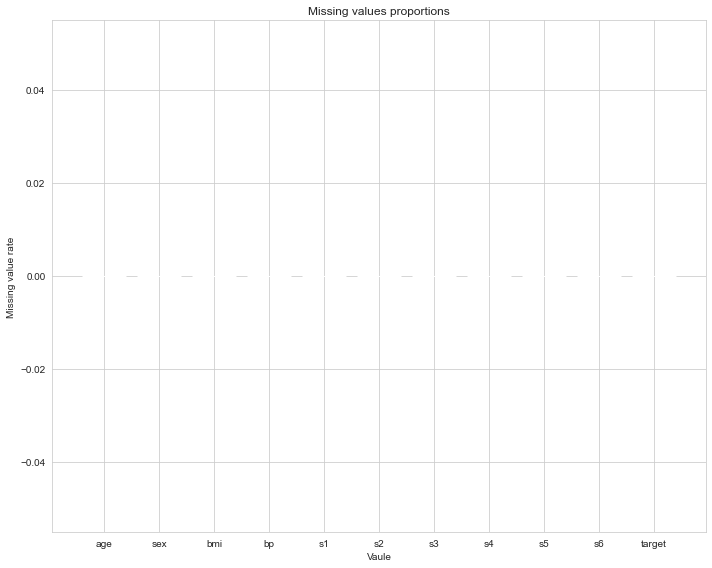



Heatmap correlations for all variables in the dataset:


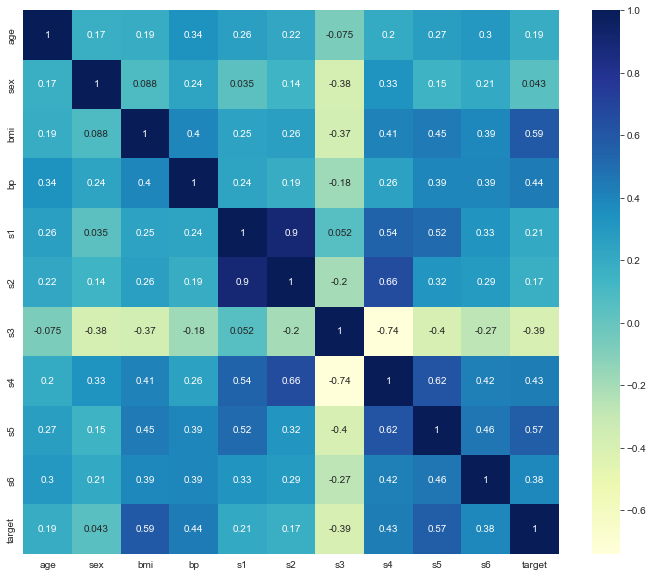



Histogram with a boxplot above it for numeric variables age, bmi, bp, s1, s2, s3, s4, s5, s6, target:


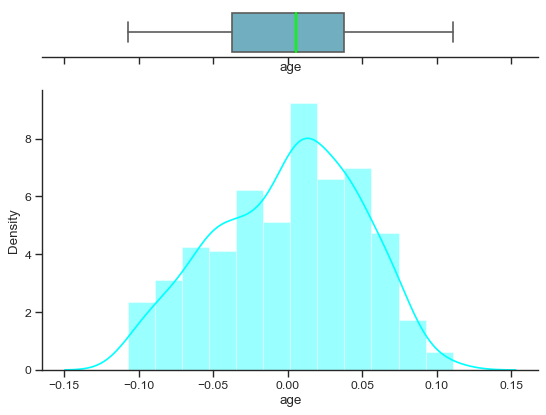

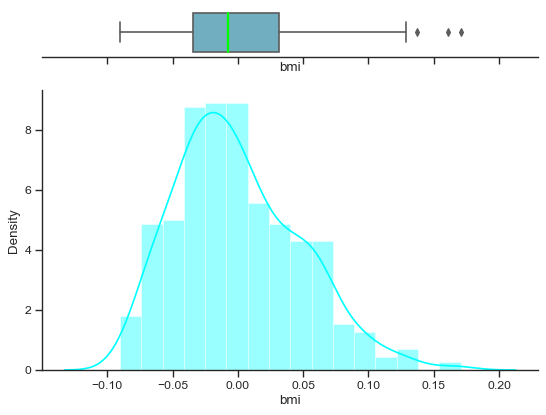

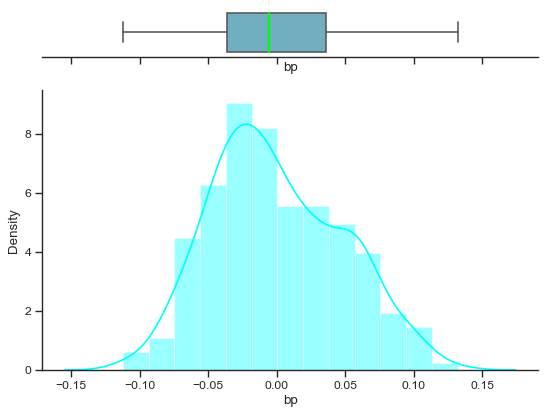

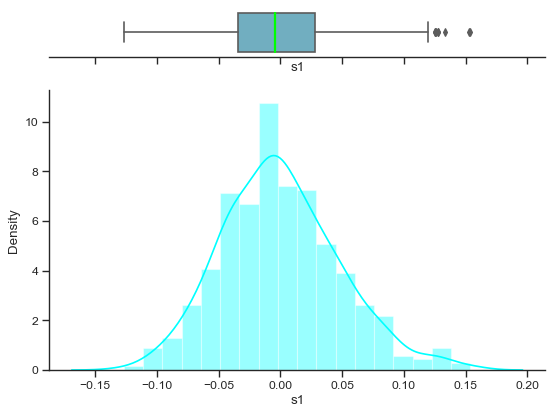

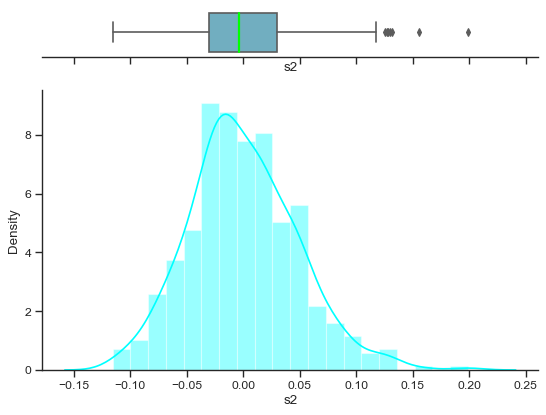

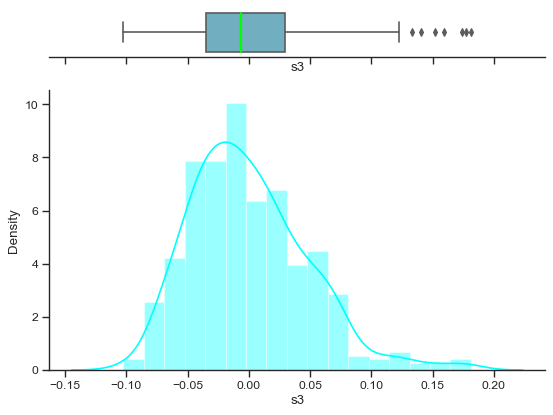

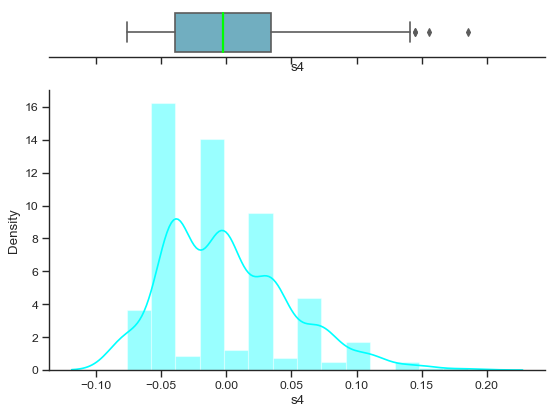

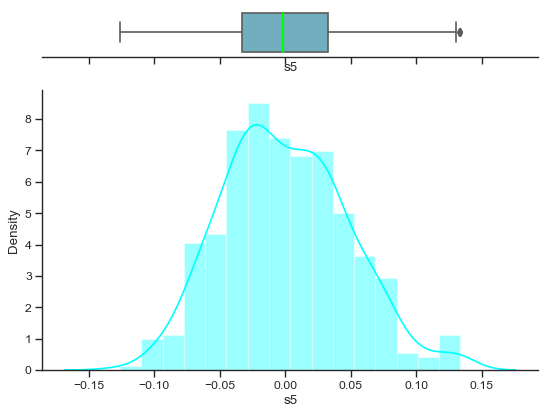

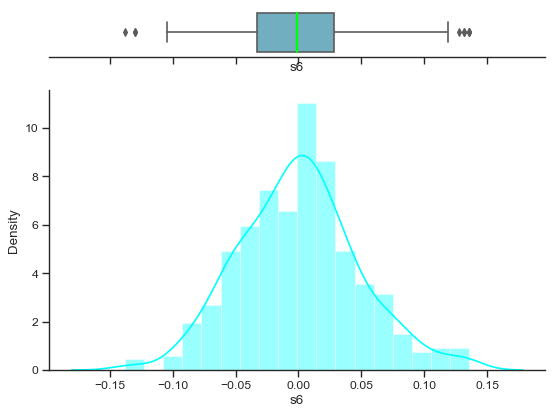

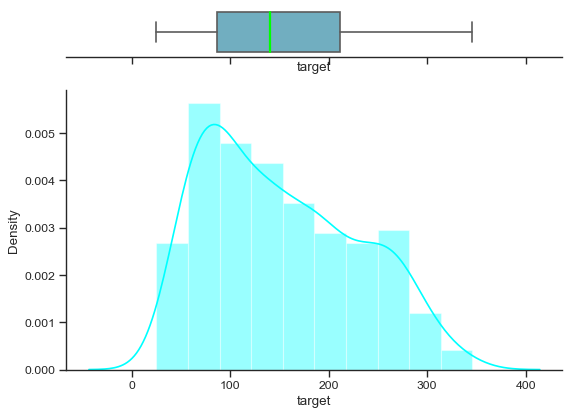

In [32]:
from my_awesome_eda import run_eda
run_eda(df)

Небольшая попытка реализации pipeline чтобы подобрать лучше параметрв

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.80)

pipe = make_pipeline(
    SimpleImputer(strategy="median"), StandardScaler(), KNeighborsRegressor()
)
param_grid = {
    "kneighborsregressor__n_neighbors": [1, 2, 4, 5, 8, 10, 30],
    "kneighborsregressor__weights": ["distance"],
}

grid = GridSearchCV(pipe, param_grid=param_grid, scoring="neg_mean_squared_error", cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('kneighborsregressor',
                                        KNeighborsRegressor())]),
             param_grid={'kneighborsregressor__n_neighbors': [1, 2, 4, 5, 8, 10,
                                                              30],
                         'kneighborsregressor__weights': ['distance']},
             scoring='neg_mean_squared_error')

In [35]:
print(f'Best parameter of the estimators is {grid.best_estimator_["kneighborsregressor"].n_neighbors} neighbors.')

Best parameter of the estimators is 30 neighbors.


### 2.2. Регрессионная модель (1 балл)

Создайте модель `KNeighborsRegressor`, обучите ее на треноровочных данных и сделайте предсказания.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.80, 
                                                    random_state=42)

In [37]:
model = KNeighborsRegressor(7)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

### 2.3. Метрики регресии (3 балла)

Реализуйте метрики $R^2$, MSE и  MAE в `metrics.py`. Примените их для оценки качества полученной модели. Все ли хорошо?

Напомню, что:

$R^2 = 1 - \frac{\sum_i^n{(y_i - \hat{y_i})^2}}{\sum_i^n{(y_i - \overline{y})^2}}$

$MSE = \frac{1}{n}\sum_i^n{(y_i - \hat{y_i})^2}$

$MAE = \frac{1}{n}\sum_i^n{|y_i - \hat{y_i}|}$

In [38]:
from metrics import r_squared, mse, mae


print(f'R squared: {round(r_squared(y_pred, y_test),3)}') 
print(f'MSE: {round(mse(y_pred, y_test),3)}') 
print(f'MAE: {round(mae(y_pred, y_test),3)}') 

R squared: 0.441
MSE: 2976.451
MAE: 42.541


### 2.4. Подбор оптимального числа соседей (2 балла)

Мы почти дошли до конца. Теперь осталось при помощи реализованных нами метрик выбрать лучшее количество соседей для нашей модели.

!!! Обратите внимание на то, что значат наши метрики, для некоторых хорошо, когда они уменьшаются, для других наоборот.

In [39]:
from metrics import r_squared, mse, mae

In [40]:
def find_best_k_lm(X_train, y_train, X_test, y_test, params):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    
    k_to_accuracies = {}
    
    for i in params:
        model = KNeighborsRegressor(i)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        from metrics import r_squared, mse, mae

        accuracy = [round(r_squared(y_pred, y_test),3), round(mse(y_pred, y_test),3), round(mae(y_pred, y_test),3)]
        k_to_accuracies[i] = accuracy
        
    return k_to_accuracies

In [41]:
params = [1, 2, 4, 5, 8, 10, 30]
k_to_accuracies = find_best_k_lm(X_train, y_train, X_test, y_test, params)
for k in k_to_accuracies:
    print(f'k = {k}')
    print(f'r_squared = {k_to_accuracies[k][0]}')
    print(f'mse = {k_to_accuracies[k][1]}')
    print(f'mae = {k_to_accuracies[k][2]}', '\n')

k = 1
r_squared = 0.254
mse = 5191.236
mae = 53.618 

k = 2
r_squared = 0.367
mse = 3537.612
mae = 45.472 

k = 4
r_squared = 0.388
mse = 3278.911
mae = 44.795 

k = 5
r_squared = 0.435
mse = 3019.076
mae = 42.771 

k = 8
r_squared = 0.441
mse = 2973.853
mae = 42.49 

k = 10
r_squared = 0.416
mse = 3115.359
mae = 45.125 

k = 30
r_squared = 0.43
mse = 3122.163
mae = 46.221 



In [42]:
metrics = list(k_to_accuracies.values())

r_squared = [row[0] for row in metrics]
mse = [row[1]/1000 for row in metrics]
mae = [row[2]/10 for row in metrics]

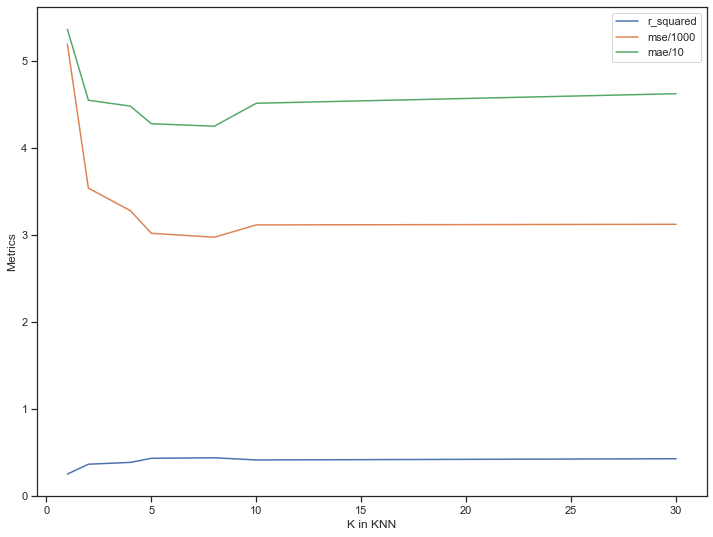

In [43]:
plt.plot(params, r_squared, label="r_squared")
plt.plot(params, mse, label="mse/1000")
plt.plot(params, mae, label="mae/10")

plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("Metrics");

При анализе MSE была поделена на 1000, MAE была поделена на 10, для более удобного графического отображения.
Лучшим количеством соседей для модели будет 8 соседей (k = 8).

Говоря о метриках, нам необходимо чтобы коэффициент детерминации был как можно ближе к 1, а mse и mae как можно меньше.

* MSE - Среднеквадратичная ошибка (Mean Squared Error) 
настроена на отражение влияния именно больших ошибок на качество модели.

* MAE - Cредняя абсолютная ошибка (Mean Absolute Error)
среднее абсолютных разностей между наблюдаемым и предсказанным значениями, является линейной оценкой, а это значит, что все ошибки в среднем взвешены одинаково, разница между 0 и 10 будет вдвое больше разницы между 0 и 5

* R-квадрат - коэффициент детерминации (Coefficient of determination)
инвариантность к масштабу данных. Кроме того, он всегда изменяется в диапазоне от −∞ до 1, значения близкие к 1 указывают на высокую степень соответствия модели данным. Отношение в формуле стремится к 0, т.е. ошибка модели с переменными намного меньше ошибки модели с константой. 

In [44]:
model = KNeighborsRegressor(8)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from metrics import r_squared, mse, mae
print(f'R squared: {r_squared(y_pred, y_test)}') 
print(f'MSE: {mse(y_pred, y_test)}') 
print(f'MAE: {mae(y_pred, y_test)}') 

R squared: 0.441
MSE: 2973.853
MAE: 42.49


### 3. Социализация (0.5 доп. балла)

Так как у нас теперь большая группа, то было бы здорово всем познакомиться получше (так как выпускной не за горами). Соберитесь с одногруппниками в зуме, познакомьтесь, а сюда прикрепите скриншот с камерами всех участников.

![title](photo.jpg)

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**

Это задание показалось мне сложным, возможно, из-за того, что это мое первое знакомтсво с манинным обучением. Некоторые задания пришлось переделывать несколько раз, потому что через какое то время внезапно осеняло, что надо было делать по-другому)
В целом, я научилась довольно многому. Единственное, мне кажется у меня так и не получилось нормально разобраться с pipeline, пока слишком сложно дя меня, возможно вернусь к нему позднее.